## Загрузим нужные библиотеки

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [20]:
N_THREADS = 20
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'blocked'

In [21]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [22]:
df_train = pd.read_csv("data/train_dataset_train.csv")
df_sample_solution = pd.read_csv("data/sample_solution.csv")

df_named = pd.read_csv("data/named.csv")
df_type_contract = pd.read_csv("data/type_contract.csv")
df_log = pd.read_csv("data/log.csv")

In [23]:
df_test = df_sample_solution[['contract_id']].copy()

In [24]:
def extract_domain(input_url: str) -> str:
    if 'sampo.ru' in input_url and 'rt.ru' in input_url:
        return 'both'
    elif 'sampo.ru' in input_url:
        return 'sampo.ru'
    elif 'rt.ru' in input_url:
        return 'rt.ru'
    else:
        return 'other'

In [25]:
df_named['url'] = df_named['url'].apply(extract_domain).astype('category')
df_named['date'] = pd.to_datetime(df_named['date'])
max_date_click = df_named['date'].max()
click_features = df_named.groupby(by=['contract_id', 'url']).count().unstack().droplevel(level=0, axis=1).reset_index().fillna(0).astype('int')

last_click_df = df_named[['contract_id', 'date']].groupby(by='contract_id').max().reset_index().rename(columns={'date': 'last_click'})
last_click_df['last_click'] = last_click_df['last_click'].apply(lambda x: (max_date_click - x).days).fillna(-1)

click_features = click_features \
    .merge(last_click_df[['last_click', 'contract_id']], on='contract_id', how='left')
click_features['total_clicks'] = click_features['rt.ru'] + click_features['sampo.ru']

In [26]:
df_log['event_type'] = df_log['event_type'].astype('category').cat.codes
df_log['event_type'] = 'log_' + df_log['event_type'].astype(str)
log_features = df_log.groupby(by=['contract_id', 'event_type']).count().unstack().droplevel(level=0, axis=1).reset_index().fillna(0).astype('int')

event_total_df = df_log[['contract_id', 'event_type']].groupby(by=['contract_id']).count().reset_index().rename(columns={'event_type': 'event_total'}).fillna(0)

df_log['event_date'] = pd.to_datetime(df_log['event_date'])
max_date = df_log['event_date'].max()

last_ev_df = df_log[['contract_id', 'event_date']].groupby(by='contract_id').max().reset_index().rename(columns={'event_date': 'last_event'})
first_ev_df = df_log[['contract_id', 'event_date']].groupby(by='contract_id').min().reset_index().rename(columns={'event_date': 'first_event'})

first_ev_df['time_between_first'] = first_ev_df['first_event'].apply(lambda x: (max_date - x).days).fillna(-1)
last_ev_df['time_between_last'] = last_ev_df['last_event'].apply(lambda x: (max_date - x).days).fillna(-1)

log_features = log_features \
    .merge(event_total_df, on='contract_id', how='left') \
    .merge(first_ev_df[['contract_id', 'time_between_first']], on='contract_id', how='left') \
    .merge(last_ev_df[['contract_id', 'time_between_last']], on='contract_id', how='left')

In [27]:
df_train = df_train \
    .merge(log_features, on='contract_id', how='left') \
    .merge(click_features, on='contract_id', how='left') \
    .merge(df_type_contract, on='contract_id', how='left')
    
df_test = df_test \
    .merge(log_features, on='contract_id', how='left') \
    .merge(click_features, on='contract_id', how='left') \
    .merge(df_type_contract, on='contract_id', how='left')

In [28]:
df_train

,contract_id,blocked,log_0,log_1,log_10,log_100,log_101,log_102,log_103,log_104,...,log_98,log_99,event_total,time_between_first,time_between_last,rt.ru,sampo.ru,last_click,total_clicks,day_or_month_contract
0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,43.0,1.0,0.0,83.0,1.0,83.0,0.0
1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,30.0,30.0,3.0,7.0,8.0,10.0,0.0
2,7794,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,52.0,36.0,NaN,NaN,NaN,NaN,1.0
4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,47.0,12.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,274601,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,9.0,9.0,NaN,NaN,NaN,NaN,1.0
5989,274710,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,9.0,9.0,NaN,NaN,NaN,NaN,0.0
5990,274782,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,14.0,7.0,NaN,NaN,NaN,NaN,0.0
5991,274786,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,14.0,0.0,1.0,0.0,25.0,1.0,1.0


In [259]:
X_train = df_train.drop(["contract_id", "blocked"], axis=1).fillna(0)
y_train = df_train[["blocked"]]

X_test = df_test.drop(["contract_id"], axis=1).fillna(0)

In [ ]:
# drop ['log_10', 'log_100', 'log_103', 'log_104', 'log_19', 'log_21', 'log_30', 'log_35', 'log_39', 'log_43', 'log_44', 'log_52', 'log_62', 'log_80', 'log_99']

## Обучение модели

In [260]:
#clf = CatBoostClassifier(random_state=0)
#clf.fit(X_train, y_train)

In [7]:
# feature_scores = pd.DataFrame({'feature': clf.feature_names_, 'score': clf.feature_importances_})
# bad_features = list(feature_scores[feature_scores['score'] == 0]['feature'])
# feature_scores.sort_values(by='score', ascending=False)

In [100]:
drop_features = ['log_72', 'log_74', 'log_80', 'log_1', 'log_7', 'log_73', 'log_75', 'log_0', 'log_77', 'log_78', 'log_8', 'log_100',
 'log_81', 'log_10', 'log_83', 'log_84', 'log_85', 'log_99', 'log_87', 'log_9', 'log_91', 'log_92', 'log_93', 'log_95', 'log_96', 'log_97', 'log_98', 'log_19', 'log_102',
 'log_65', 'log_30', 'log_43', 'log_39', 'log_38', 'log_14', 'log_35', 'log_15', 'log_32', 'log_31', 'log_16', 'log_64', 'log_28', 'log_27', 'log_26', 'log_25', 'log_24',
 'log_17', 'log_21', 'log_20', 'log_44', 'log_45', 'log_13', 'log_47', 'log_101', 'log_62', 'log_2', 'log_103', 'log_6', 'log_59', 'log_58', 'log_57', 'log_56', 'log_55',
 'log_54', 'log_104', 'log_11', 'log_51', 'log_50', 'log_5', 'log_12', 'log_52']

In [127]:
task = Task('binary',
            metric=lambda y_true, y_pred: recall_score(y_true, (y_pred > 0.1)*1, average='macro'),
            greater_is_better=True
)

roles = {
    'target': TARGET_NAME,
    'category': ['day_or_month_contract'],
    'id': ['contract_id'],
    'drop': drop_features
}

In [128]:
model = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [129]:
oof_pred = model.fit_predict(df_train, roles=roles, verbose=1)

[21:39:24] Stdout logging level is INFO.
[21:39:24] Task: binary

[21:39:24] Start automl preset with listed constraints:
[21:39:24] - time: 300.00 seconds
[21:39:24] - CPU: 20 cores
[21:39:24] - memory: 16 GB

[21:39:24] Train data shape: (5993, 115)

[21:39:26] Layer 1 train process start. Time left 297.76 secs
[21:39:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:39:28] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.707840288318709
[21:39:28] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:39:28] Time left 295.81 secs

[21:39:29] Selector_LightGBM fitting and predicting completed
[21:39:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[21:39:32] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7259639709841419
[21:39:32] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:39:32] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 52.10 secs


e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be rem

[21:40:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[21:40:25] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[21:40:27] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7358471932487534
[21:40:27] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[21:40:27] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[21:40:30] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7133599032443971
[21:40:30] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:40:30] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 165.35 secs


e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  trial_values[parameter] = getattr(trial, OPTUNA_DISTRIBUTIONS_MAP[SearchSpace.distribution_type])(
e:\projects\telecom_scoring\venv\lib\site-packages\lightautoml\ml_algo\tuning\optuna.py:231: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will 

[21:41:27] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[21:41:27] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[21:41:30] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7177198578969726
[21:41:30] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[21:41:30] Time left 173.79 secs

[21:41:30] Layer 1 training completed.

[21:41:30] Blending: optimization starts with equal weights and score 0.7279366921813573
[21:41:30] Blending: iteration 0: score = 0.7340656293037439, weights = [0.07356893 0.         0.8741106  0.         0.0523205 ]
[21:41:30] Blending: iteration 1: score = 0.7340656293037439, weights = [0.07356893 0.         0.8741106  0.         0.0523205 ]
[21:41:30] Blending: no score update. Terminated

[21:41:30] Automl preset training completed in 126.31 seconds

[21:41:30] Model description:
Final prediction for new objects (level 0) = 
	 0.07357 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.87411

In [138]:
oof_res = pd.DataFrame({'contract_id': df_train['contract_id'], 'prob': oof_pred.data.reshape(-1)})
oof_res['blocked'] = oof_res['prob'].apply(lambda x: 1 if x > 0.11 else 0)
recall_score(df_train['blocked'].values, oof_res['blocked'].values, average='macro')

0.7353299999188292

In [139]:
df_test['prob'] = model.predict(df_test).data.reshape(-1)
df_test['blocked'] = df_test['prob'].apply(lambda x: 1 if x > 0.11 else 0)

<AxesSubplot: >

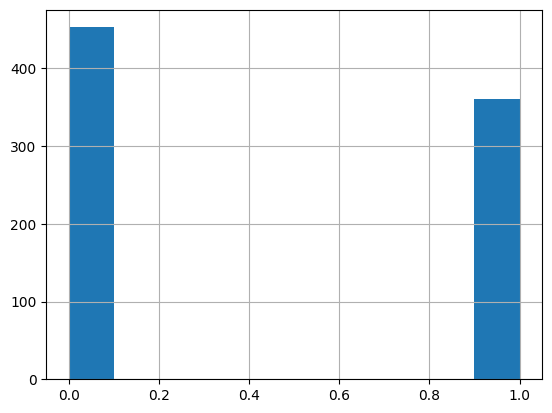

In [140]:
df_test['blocked'].hist()

In [141]:
df_test[['contract_id', 'blocked']].to_csv('subs/submission_4.csv', index=False)

In [142]:
feature_importance = model.get_feature_scores()

In [143]:
list(feature_importance[feature_importance['Importance'] == 0]['Feature'])

['log_42',
 'log_37',
 'log_18',
 'log_3',
 'log_33',
 'log_88',
 'log_94',
 'log_69',
 'log_71',
 'log_66']

In [23]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.49873817034700313
